In [1]:
## Bring in needed mods
import numpy as np, pandas as pd, scipy.stats as ss, seaborn as sns, os
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Set random seed
np.random.seed(71191)

In [3]:
## Set chrom colors for use in ploting
chrom_colors = ['tab:grey','tab:brown','lightgrey',
                'salmon','tan']

In [4]:
## Define ftns for use
def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. 
    Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    #R = len_yhat/len_y
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F


def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [5]:
## Set path and bring in genotype data, view first few rows
geno_path = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
gv = pd.read_csv(geno_path)
gv.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [6]:
## Set path and bring in phenotype data
data_path = '../DATA/PHENOTYPE/OSMOTIC/osmotic-stress-Jun262020.csv'
data = pd.read_csv(data_path)
data.head()

,row,column,plate,rep,NaCl,centroid_r,centroid_c,area,perimeter,major_axis_length,...,eccentricity,equiv_diameter,mean_intensity,solidity,convex_area,bbox_minr,bbox_minc,bbox_maxr,bbox_maxc,strain
0,b,11,2,0,0.5,224.894616,221.187858,873.0,108.568543,34.246921,...,0.318409,33.339738,37166.26346,0.974330,896.0,209.0,204.0,242.0,239.0,SS-B317
1,b,11,2,0,0.0,227.867304,225.772047,2404.0,179.923882,56.610843,...,0.295699,55.325111,25473.69384,0.987269,2435.0,201.0,198.0,256.0,254.0,SS-B317
2,b,11,2,1,0.5,187.951144,202.854470,962.0,113.396970,35.594194,...,0.253728,34.997949,37633.77547,0.983640,978.0,171.0,186.0,207.0,221.0,SS-B317
3,b,11,2,1,0.0,227.544070,232.059529,2167.0,171.681241,53.915537,...,0.314155,52.527232,26092.21827,0.983212,2204.0,201.0,207.0,255.0,259.0,SS-B317
4,b,11,2,2,0.5,214.549139,232.950355,987.0,116.225397,37.695872,...,0.465058,35.449787,36972.21175,0.975296,1012.0,196.0,216.0,234.0,251.0,SS-B317


In [7]:
## Check data shape
data.shape

(1080, 21)

In [8]:
## Replace missing values with a mean intensity of 56000 (no growth)
## "This is the maximum mean intensity" - DM
data['mean_intensity'] = data['mean_intensity'].fillna(56000.0)

In [9]:
## Strian by replicate by NaCl concentration counts are what?
data.groupby(['strain','NaCl']).count().T.head()

strain     SS-A837         SS-B307         SS-B308         SS-B310  ...  \
NaCl           0.0 0.5 1.0     0.0 0.5 1.0     0.0 0.5 1.0     0.0  ...   
row              3   3   3       3   3   3       3   3   3       3  ...   
column           3   3   3       3   3   3       3   3   3       3  ...   
plate            3   3   3       3   3   3       3   3   3       3  ...   
rep              3   3   3       3   3   3       3   3   3       3  ...   
centroid_r       3   3   2       3   1   1       3   3   1       3  ...   

strain     SS-C290 SS-C291         XL280a         XL280alpha          
NaCl           1.0     0.0 0.5 1.0    0.0 0.5 1.0        0.0 0.5 1.0  
row              3       3   3   3      3   3   3          3   3   3  
column           3       3   3   3      3   3   3          3   3   3  
plate            3       3   3   3      3   3   3          3   3   3  
rep              3       3   3   3      3   3   3          3   3   3  
centroid_r       2       3   3   2      3   3   1          3   3   3  

[5 rows x 357 columns]

In [10]:
## Define parental strains
parentals = ['XL280a','XL280alpha','SS-A837']

In [11]:
## Group by replicate and average group by strain and average
## One strain is duplicated per plate
osmorep = data.groupby(['NaCl','strain','rep']).agg(np.nanmean)
osmorep.reset_index(inplace=True)

## Take the average across replicates
osmo = osmorep.groupby(['NaCl','strain']).agg(np.nanmean)
osmo.reset_index(inplace=True)

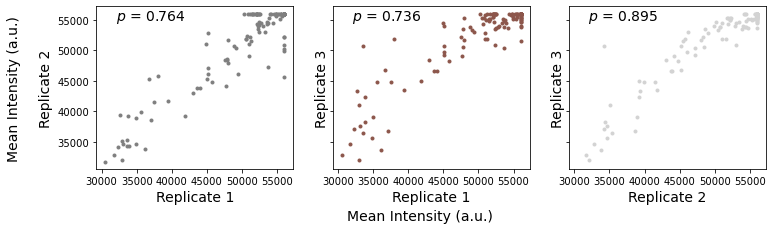

In [12]:
## Check the reproducability across replicates
NaCl1_reps = osmorep[(osmorep.NaCl==1.0)].sort_values('strain')

fig,ax = plt.subplots(1,3,figsize=(12,3),sharex=True,sharey=True);


for i,(k,j) in enumerate([(0,1),(0,2),(1,2)]):
    
    plt.sca(ax[i])
    x = NaCl1_reps[(NaCl1_reps.rep==k)].mean_intensity.values
    y = NaCl1_reps[(NaCl1_reps.rep==j)].mean_intensity.values
    sp = np.round(ss.spearmanr(x,y)[0],3)
    plt.xlabel('Replicate %s'%str(k+1),fontsize=14)
    plt.ylabel('Replicate %s'%str(j+1),fontsize=14)
    plt.text(32000,55000,s='$p$ = %s'%sp,fontsize=14)
    
    
    plt.plot(x,y,'.',color=chrom_colors[i]);

fig.text(0.03,0.5,'Mean Intensity (a.u.)',
         fontsize=14,rotation=90,va='center',ha='center')

fig.text(0.5,-0.09,"Mean Intensity (a.u.)",
         fontsize=14,ha='center',va='center');
plt.savefig('/home/croth/Desktop/QTL_REPLICATES/Osmotic_replicates_rank_coeff.png',
           dpi=100,bbox_inches='tight');

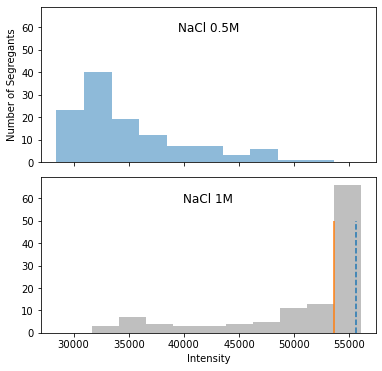

In [13]:
## Plot a histogram of the data
fig,ax = plt.subplots(2,1,figsize=(6,6),
                      sharex=True,sharey=True)
plt.sca(ax[0])
plt.hist(osmo[(osmo.NaCl==0.5)]['mean_intensity'],alpha=0.5);
plt.title('NaCl 0.5M',x=0.5,y=0.8);
plt.ylabel('Number of Segregants')
plt.sca(ax[1])
plt.title('NaCl 1M',x=0.5,y=0.8)
plt.hist(osmo[(osmo.NaCl==1)]['mean_intensity'],color='grey',alpha=0.5);
plt.vlines(osmo[(osmo.NaCl==1.0) & 
                (osmo.strain=='SS-A837')]['mean_intensity'],
           0,50,linestyles='-',color='tab:orange')
plt.vlines(osmo[(osmo.NaCl==1.0) & 
                (osmo.strain=='XL280a')]['mean_intensity'],
           0,50,linestyles='--',color='tab:blue')

plt.xlabel('Intensity');
plt.subplots_adjust(hspace=0.1);

In [14]:
## Gather the segregant strain names for QTL mapping
segs = np.array([s 
                 for s in osmo.strain.unique() 
                 if s in gv.columns])
len(segs)

104

In [15]:
## Make the index of the average phenotype data
## the strain name
osmo.index = osmo.strain

In [16]:
## Inital analysis did not identify QTL for 0.5 M of NaCl
## Take data for 1 M
pheno = osmo[(osmo.NaCl==1)]

In [17]:
## Gather unique haplogroups by strain
test = gv[segs].drop_duplicates()

## Conduct QTL mapping
test['1M'] = test.apply(association_logPval,args=[pheno.T[segs].T['mean_intensity']],axis=1)

## Merge results with data frame
pval_df = gv.merge(test)

## Save resluts
pval_df.to_csv('../DATA/PHENOTYPE/OSMOTIC/Cdx_osmotic_1M_pvalues.csv.gz',index=True)

## View frist few rows
pval_df.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,1M
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.066362


In [18]:
## Gather chromosome information
## including a list of chromosome
## there lenghts, cummulative length etc
chrlist = sorted(pval_df.Chrom.unique())
chrlens = np.array([pval_df[(pval_df.Chrom==c)].Pos.max() 
           for c in chrlist])
cumpos = np.array([0] + list(np.cumsum(chrlens[:-1])))
cummax = cumpos[-1] + pval_df[(pval_df.Chrom=='Chr14')].Pos.max()
chrmid = (chrlens/2) + cumpos

In [19]:
## Bring in other needed mods
from PIL import Image
from matplotlib import rc
plt.style.use(['tableau-colorblind10'])

In [20]:
## Bring in the null distribution of association
perms = pd.read_csv('../DATA/PERMUTATIONS/Cdx_osmo_NaCl_1M_perms_10000_null.csv.gz',
                    index_col=0)

## Gather thresholds
alpha005 = np.percentile(perms.Pval.values,95)
alpha001 = np.percentile(perms.Pval.values,99)

In [21]:
## Find bounds and peak index from threshold
qtl10_ix = pval_df[(pval_df['1M']>alpha005) & (pval_df.Chrom=='Chr10')].index
qtl10_block = gv.T[qtl10_ix].T['Block']
qtl10_gv = gv[(gv.Block.isin(qtl10_block))]
qtl10_bounds = (qtl10_gv.Pos.min(),qtl10_gv.Pos.max())
print(qtl10_bounds)
print(np.diff(qtl10_bounds)[0])

(952008, 995555)
43547


In [22]:
## Take genotype data for QTL
qtl10_ix = pval_df[(pval_df.Chrom=='Chr10')]['1M'].idxmax()
pxg = osmo[(osmo.NaCl==1)][['mean_intensity']].copy()
pxg['qtl10'] = gv.T[qtl10_ix][[s for s in pheno.index if s in gv.columns]]
pxg['qtl10'] = pxg.qtl10.apply(float)
pxg.dropna(inplace=True)
pxg.shape

(104, 2)

In [23]:
## Estiamte heritabilty at QTL on chromosome 10
## Bring in needed mods
import statsmodels.formula.api as smf

## Make a model
mod = smf.ols(formula='mean_intensity~qtl10', data=pxg)
res = mod.fit()

## Print summary
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mean_intensity   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     22.22
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           7.72e-06
Time:                        15:15:48   Log-Likelihood:                -1054.0
No. Observations:                 104   AIC:                             2112.
Df Residuals:                     102   BIC:                             2117.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.831e+04    815.715     59.224      0.000    4.67e+04    4.99e+04
qtl10       5719.8047   1213.405      4.714      0.000    3313.021    8126.589
==============================================================================
Omnibus:                       12.559   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.821
Skew:                          -0.888   Prob(JB):                     0.000997
Kurtosis:                       3.186   Cond. No.                         2.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

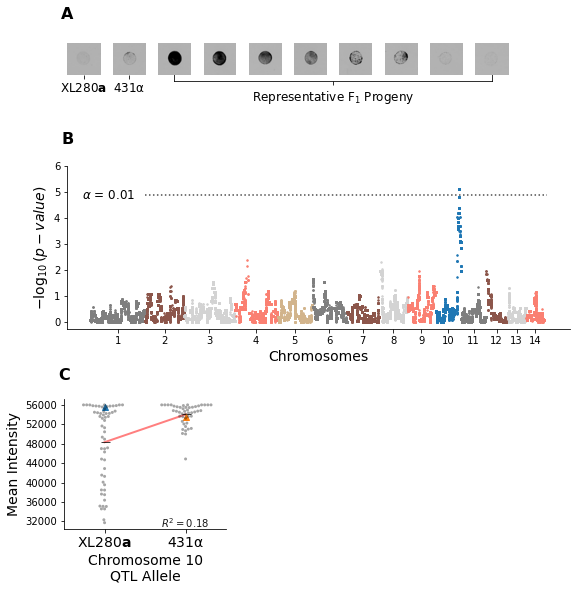

In [24]:
## Plot supplementary Figrue S18
fig,ax = plt.subplots(1,1,figsize=(9,3),sharex=True,sharey=True)

for c in chrlist:
    i = int(c[3:])-1
    
    if c == 'Chr10':
        cc = 'tab:blue'
    else:
        cc = chrom_colors[i%len(chrom_colors)]
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos.values+cumpos[i],temp['1M'].values,'.',color=cc,ms=3);
    
plt.xticks(chrmid,np.arange(len(chrlist))+1);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
plt.hlines(alpha001,chrlens[0],19*(10**6),color='k',alpha=0.7,
           linestyles='dotted')


plt.yticks(np.arange(7))
[ax.spines[s].set_visible(False) for s in ['top','right']]



plt.title('B',x=0,y=1.1,fontweight='bold',fontsize=16)
plt.text(s = r'$\alpha$ = 0.01', x = (2/3)*chrmid[0],y= alpha001,
         horizontalalignment='center',
         verticalalignment='center', fontsize=12)


plt.sca(ax)
axs = fig.add_axes([0.29,1.27,.49,.1])
plt.xticks([0.5],labels=['Representative F$_{1}$ Progeny'],fontsize=12)
plt.yticks([ ],labels=None)
axs.spines['top'].set_visible(False) 


## Plot xl280a
plt.sca(ax)
axm = fig.add_axes([0.1,1.3,0.1,.15])
xl280a_path = '../IMAGES/osmo_crop_segs/xl280a.png'
xl280a_obj = Image.open(xl280a_path)
plt.imshow(xl280a_obj),# aspect='auto')
plt.xticks([np.array(xl280a_obj).shape[0]/2],labels=['XL280'+ r'$\bf{a}$'],fontsize=12)
plt.yticks([]);
plt.title('A',fontsize=16,fontweight='bold',x=0,y=1.54);
[axm.spines[a].set_visible(False) for a in ['top','bottom','left','right']]

## Plot 431
plt.sca(ax)
axm = fig.add_axes([0.17,1.3,0.1,.15])
plt.yticks([]);
A837_path = '../IMAGES/osmo_crop_segs/431alpha.png'
A837_obj = Image.open(A837_path)
plt.imshow(A837_obj),# aspect='auto')
plt.xticks([np.array(A837_obj).shape[0]/2],labels=['431'+'$\mathrm{\u03B1}$'],fontsize=12)
[axm.spines[a].set_visible(False) for a in ['top','bottom','left','right']]


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.24,1.3,0.1,.15])
plt.yticks([]);
spath = '../IMAGES/osmo_crop_segs/d11.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.31,1.3,0.1,.15])
plt.yticks([]);
spath = '../IMAGES/osmo_crop_segs/c4.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S1
axm = fig.add_axes([0.38,1.3,0.1,.15])
plt.yticks([]);
spath = '../IMAGES/osmo_crop_segs/f3.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.45,1.3,0.1,.15])
plt.yticks([]);
spath = '../IMAGES/osmo_crop_segs/d10.png' 
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.52,1.3,0.1,.15])
plt.yticks([]);
spath = '../IMAGES/osmo_crop_segs/b5.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.59,1.3,0.1,.15])
plt.yticks([]);
spath = '../IMAGES/osmo_crop_segs/f5.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.66,1.3,0.1,.15])
plt.yticks([]);
spath = '../IMAGES/osmo_crop_segs/d4.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

plt.sca(ax)
## Plot S4
axm = fig.add_axes([0.73,1.3,0.1,.15])
plt.yticks([]);
spath = '../IMAGES/osmo_crop_segs/e3.png'
sobj = Image.open(spath)
plt.imshow(sobj),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

axr = fig.add_axes([0.12,-.8,0.25,0.6])


sns.regplot(x='qtl10',y='mean_intensity',data=pxg,
          ci=False,scatter_kws={'alpha':0.0},
        line_kws={'linewidth':2,'alpha':0.5,'color':'r'})


sns.swarmplot(x='qtl10',y='mean_intensity',
              data=pxg,size=3,
                rasterized=True,
                color='k',
                alpha=.35)

plt.plot(pxg.groupby('qtl10').mean().index,
         pxg.groupby('qtl10').mean()['mean_intensity'].values,
         'k_',alpha=0.75,markersize=9)


plt.plot(*pxg.T['XL280a'].T[['qtl10','mean_intensity']].values,
         '^',color='tab:blue')
plt.plot(*pxg.T['SS-A837'].T[['qtl10','mean_intensity']].values,
         '^',color='tab:orange')


plt.title('C',fontsize=16,fontweight='bold',x=0,y=1.1)
plt.ylabel('Mean Intensity',fontsize=14);
plt.xlabel('Chromosome 10\nQTL Allele',fontsize=14)
plt.xticks([0,1],['XL280'+ r'$\bf{a}$',
                  '431'+'$\mathrm{\u03B1}$'],fontsize=14)
plt.text(y= pxg.mean_intensity.min() ,
         x= np.abs(pxg.T[pxg.mean_intensity.idxmin()].T['qtl10'] - 1) ,
         s='$R^2 = %s$'%(np.round(res.rsquared,2)),
         va='center',ha='center',color='k',alpha=0.9)
plt.yticks(np.arange(pxg.mean_intensity.max(),
                     pxg.mean_intensity.min(),-4000))
[axr.spines[s].set_visible(False) for s in ['top','right']]

plt.savefig('../FIGURES/SUPP/PDFs/S18_Fig.pdf',
            dpi=150,bbox_inches='tight');

In [25]:
## Save out mean phenotype data for later analysis
pheno.to_csv('../DATA/PHENOTYPE/OSMOTIC/Cdx_osmo_NaCl_1M.csv.gz',index=False);